In [41]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
RANDOM_STATE = 42

%matplotlib inline

## Data Analysis

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
# Checking for null values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

``` There aren't any null values ```

In [5]:
# Toal count of each gender
df['gender'].value_counts(normalize=True)

gender
Female    0.58552
Male      0.41430
Other     0.00018
Name: proportion, dtype: float64

``` Some of the gender values are unknown. We should remove them```

<Axes: xlabel='gender', ylabel='count'>

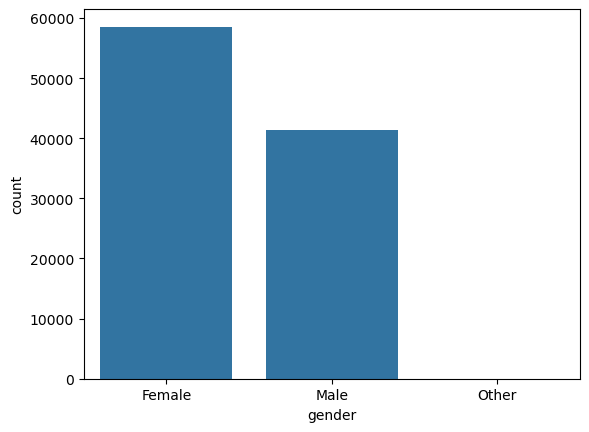

In [6]:
# Count plot Gender
sns.countplot(x=df['gender'])

In [7]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of Age')

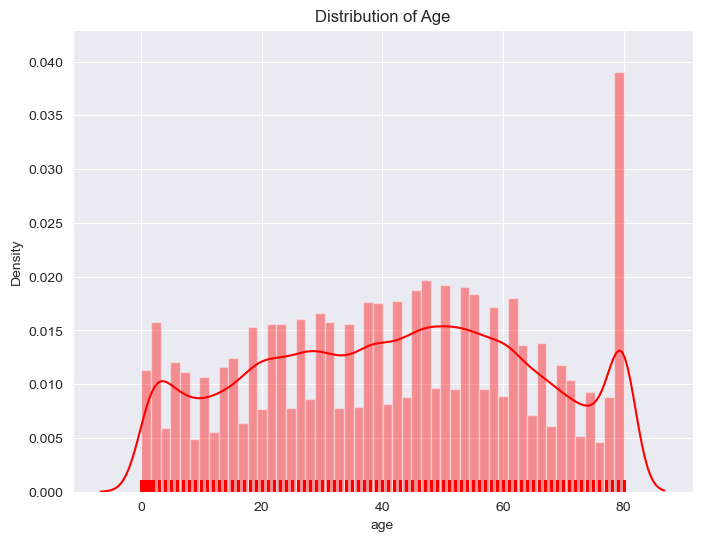

In [8]:
# Distribution of age
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.distplot(df['age'], kde=True, rug=True, color='red')
plt.title("Distribution of Age")

In [9]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

``` "age" is not normally distributed and there are more people with the age range between 40-60  and people with age 78-80```

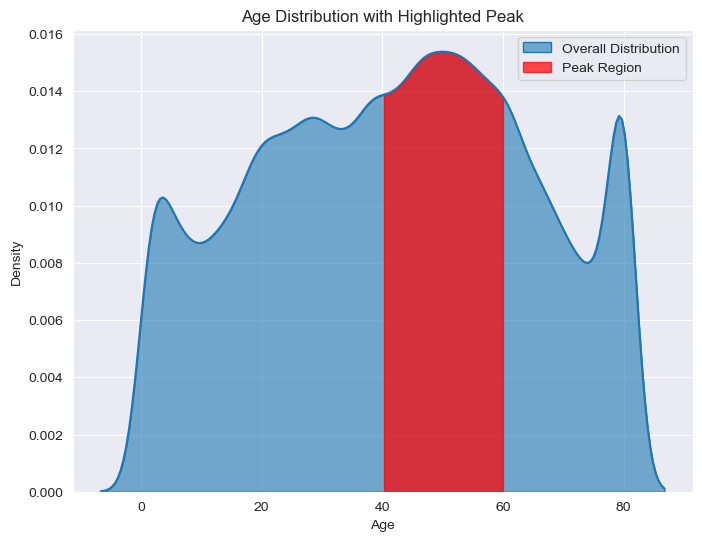

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))

# Plot the overall distribution
sns.kdeplot(df['age'], shade=True, alpha=0.6, label='Overall Distribution')

kde = sns.kdeplot(df['age'], shade=False).get_lines()[0].get_data()
x, y = kde[0], kde[1]

# Highlight the range around the peak density
peak_idx = np.argmax(y)
highlight_x = x[(x > x[peak_idx] - 10) & (x < x[peak_idx] + 10)]  # 5-unit range around peak
highlight_y = y[(x > x[peak_idx] - 10) & (x < x[peak_idx] + 10)]

plt.fill_between(highlight_x, highlight_y, color='red', alpha=0.7, label='Peak Region')

plt.title("Age Distribution with Highlighted Peak")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()

In [11]:
# Total percentage of people with hypertension
df['hypertension'].value_counts(normalize=True)

hypertension
0    0.92515
1    0.07485
Name: proportion, dtype: float64

Text(0, 0.5, 'Count')

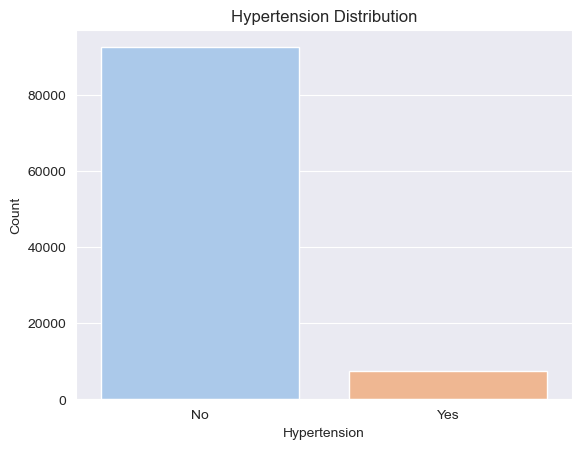

In [12]:
sns.countplot(x=df['hypertension'], palette="pastel")
plt.xticks([0, 1], ['No', 'Yes'])

plt.title("Hypertension Distribution")
plt.xlabel("Hypertension")
plt.ylabel("Count")

In [13]:
# Calculate the percentage
gender_hypertension = df.groupby('gender')['hypertension'].mean() * 100

# Display the results
for gender, percentage in gender_hypertension.items():
    print(f"{gender}: {percentage:.2f}% have hypertension")

Female: 7.17% have hypertension
Male: 7.94% have hypertension
Other: 0.00% have hypertension


In [14]:
# Total percentage of people with heart diseases
df['heart_disease'].value_counts(True)

heart_disease
0    0.96058
1    0.03942
Name: proportion, dtype: float64

Text(0, 0.5, 'Count')

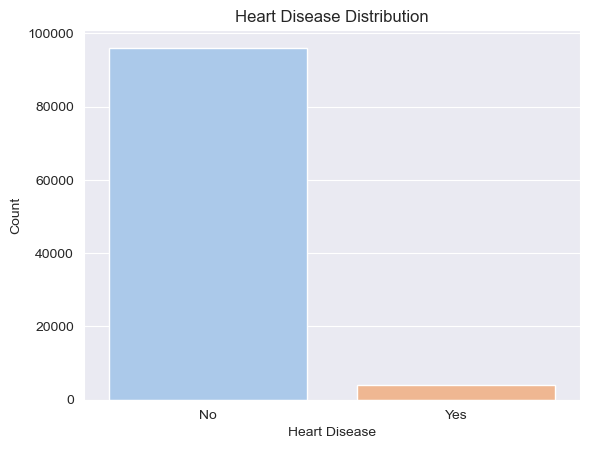

In [15]:
sns.countplot(x=df['heart_disease'], palette="pastel")
plt.xticks([0, 1], ['No', 'Yes'])

plt.title("Heart Disease Distribution")
plt.xlabel("Heart Disease")
plt.ylabel("Count")

``` Very few people have Heart Disease. Only 0.039% have heart diseases.```

In [16]:
# People having smoking history
df['smoking_history'].value_counts(True)

smoking_history
No Info        0.35816
never          0.35095
former         0.09352
current        0.09286
not current    0.06447
ever           0.04004
Name: proportion, dtype: float64

Text(0, 0.5, 'Count')

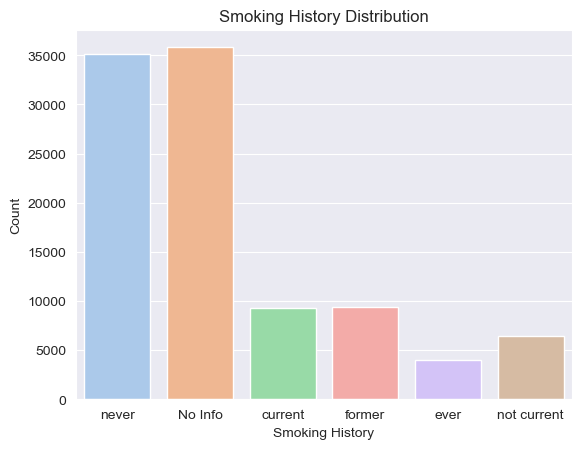

In [17]:
sns.countplot(x=df['smoking_history'], palette="pastel")

plt.title("Smoking History Distribution")
plt.xlabel("Smoking History")
plt.ylabel("Count")

In [18]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

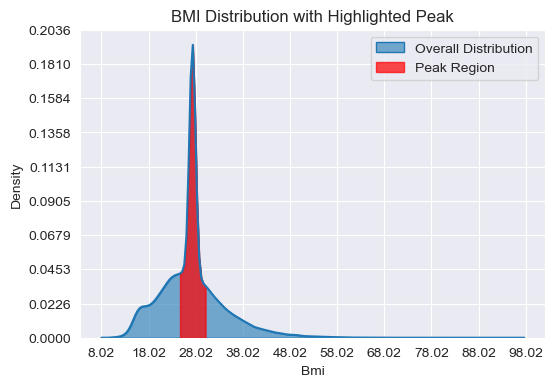

In [19]:
# Bmi distribution
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))

# Plot the overall distribution
sns.kdeplot(df['bmi'], shade=True, alpha=0.6, label='Overall Distribution')

kde = sns.kdeplot(df['bmi'], shade=False).get_lines()[0].get_data()
x, y = kde[0], kde[1]

peak_idx = np.argmax(y)
highlight_x = x[(x > x[peak_idx] - 3) & (x < x[peak_idx] + 3)]  # 5-unit range around peak
highlight_y = y[(x > x[peak_idx] - 3) & (x < x[peak_idx] + 3)]

plt.fill_between(highlight_x, highlight_y, color='red', alpha=0.7, label='Peak Region')


x_ticks = np.arange(min(x), max(x) + 10, 10)  # Tick positions for x-axis
y_ticks = np.linspace(0, max(y) + 0.01, 10)  # Tick positions for y-axis
plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.title("BMI Distribution with Highlighted Peak")
plt.xlabel("Bmi")
plt.ylabel("Density")
plt.legend()

In [20]:
# Distribution of HbA1c_level 
df['HbA1c_level'].value_counts(True)

HbA1c_level
6.6    0.08540
5.7    0.08413
6.5    0.08362
5.8    0.08321
6.0    0.08295
6.2    0.08269
6.1    0.08048
3.5    0.07662
4.8    0.07597
4.5    0.07585
4.0    0.07542
5.0    0.07471
8.8    0.00661
8.2    0.00661
9.0    0.00654
7.5    0.00643
6.8    0.00642
7.0    0.00634
Name: proportion, dtype: float64

<Axes: ylabel='Density'>

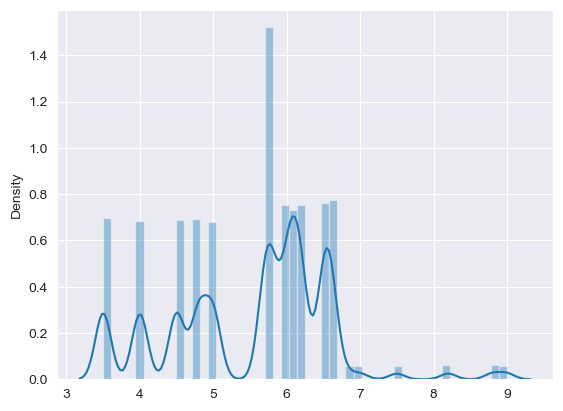

In [21]:
sns.distplot(x=df['HbA1c_level'])

<Axes: xlabel='blood_glucose_level'>

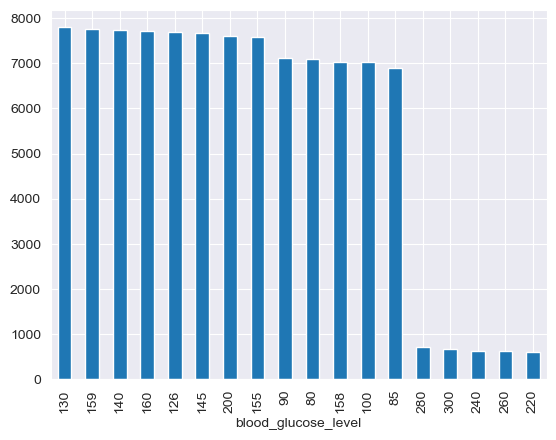

In [22]:
# Distribution of blood_glucose_level'
df['blood_glucose_level'].value_counts().plot(kind='bar')

In [23]:
## Distribution of Target Variable 'diabetes'
df['diabetes'].value_counts(True)

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

``` 0.91% of the people donot have diabetes ```

Text(0, 0.5, 'Count')

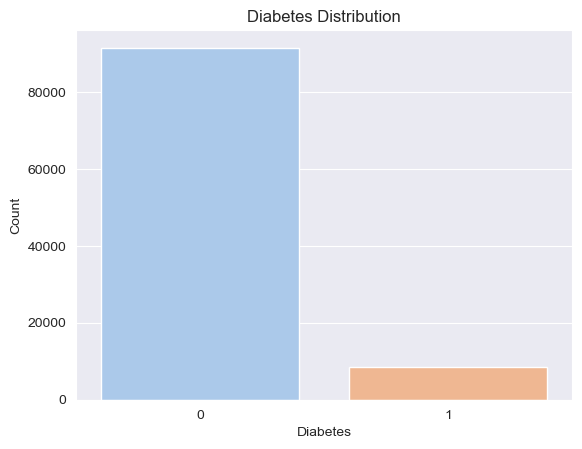

In [24]:
sns.countplot(x=df['diabetes'], palette="pastel")

plt.title("Diabetes Distribution")
plt.xlabel("Diabetes")
plt.ylabel("Count")

``` So the dataset is imabalance. Toal no of people with diabetes are less than people without diabetes. ```

## Data Preprocessing

In [25]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [26]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [27]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [28]:
df_1 = df.copy()

# First we remove the people with unknown gender
df_1 = df_1[df['gender'] != 'Other']

# Ecode the gender column
df_1 = pd.get_dummies(data=df_1, columns=['gender'], drop_first=True)

# Now we label 'smoking_history'
df_1 = pd.get_dummies(data=df_1, columns=['smoking_history'], prefix='smoking_history')

# Now change True and False to int
df_1 = df_1.replace({True:1, False:0})

In [29]:
df_1.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0


## Model Training

In [30]:
# Splitting the data into training and test
X = df_1.drop('diabetes', axis=1)
y = df_1[['diabetes']]

X.shape, y.shape

((99982, 13), (99982, 1))

In [34]:
# Now Train and Test
# Split the data into training and testing sets (80% train /20% test)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,
                                                 random_state=RANDOM_STATE)

print(f"X_train, y_train: {X_train.shape, y_train.shape}")
print(f"X_test, y_test: {X_test.shape, y_test.shape}")

X_train, y_train: ((79985, 13), (79985, 1))
X_test, y_test: ((19997, 13), (19997, 1))


In [42]:

def evaluate_model(model_name: str, model):
    print(f"Evaluating {model_name}...")

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train,
                                cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print(f"Cross-Validation Accuracy for {model_name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Fit the model on training data
    model.fit(X_train,y_train)
    
    # Predictions on test set
    y_pred = model.predict(X_test)
    
    # Classification Report on test set
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test,y_pred))
    
    # Confusion Matrix Plot on test set
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # ROC AUC Score and Curve on test set (if applicable)
    if hasattr(model,"predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test,y_prob)
        fpr,tpr,_ = roc_curve(y_test,y_prob)
        
        plt.plot(fpr,tpr,label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0 ,1], [0 ,1], 'k--', lw=2)
        plt.xlim([0.00 ,1.00])
        plt.ylim([0.00 ,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    # Feature Importance Plot (if applicable)
    if hasattr(model,'feature_importances_'):
        importances = model.feature_importances_
        features = X.columns
        plt.figure(figsize=(10 ,6))
        sns.barplot(x=importances,y=features)
        plt.title(f'{model_name} Feature Importance')
        plt.show()

    # Return evaluation metrics on test set predictions
    precision = np.round(precision_score(y_test,y_pred),4)
    recall = np.round(recall_score(y_test,y_pred),4)
    f1 = np.round(f1_score(y_test,y_pred),4)

    if hasattr(model,"predict_proba"):
        roc_auc = np.round(roc_auc_score(y_test,y_prob),4)
    else:
        roc_auc = "N/A" # Some models might not have predict_proba
    
    return {
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'CV Accuracy': np.round(cv_scores.mean(),4),
        'CV Std Dev': np.round(cv_scores.std(),4)
    }


### Decision Tree

Evaluating Decision Tree...
Cross-Validation Accuracy for Decision Tree: 0.9519 ± 0.0012
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18297
           1       0.70      0.74      0.72      1700

    accuracy                           0.95     19997
   macro avg       0.84      0.86      0.85     19997
weighted avg       0.95      0.95      0.95     19997



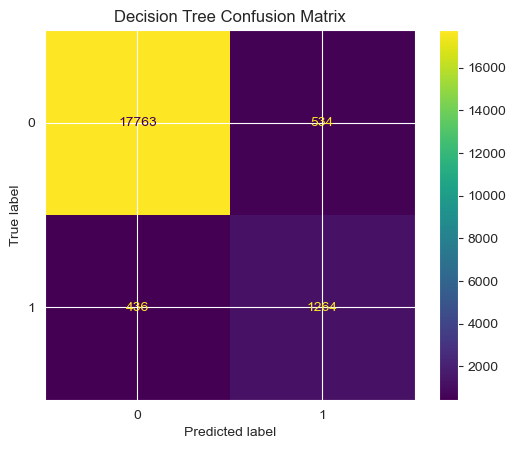

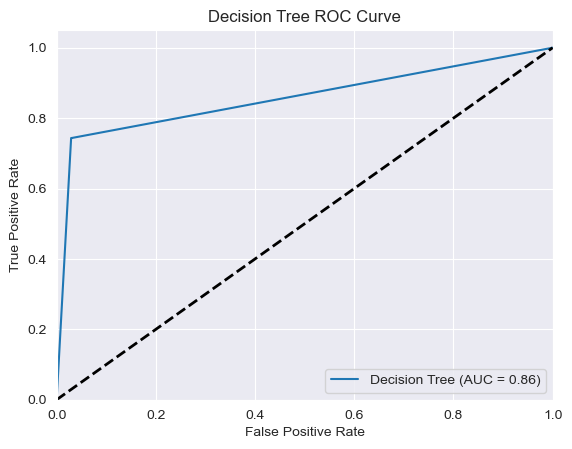

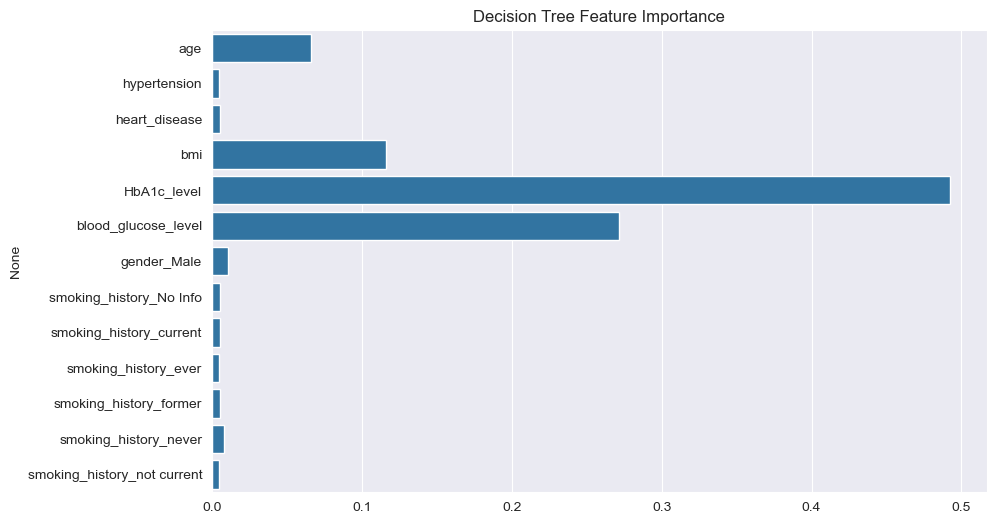

{'Model': 'Decision Tree', 'Precision': 0.703, 'Recall': 0.7435, 'F1 Score': 0.7227, 'ROC AUC': 0.857, 'CV Accuracy': 0.9519, 'CV Std Dev': 0.0012}


In [47]:
# Decision Tree Classifier with default parameters
decision_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Evaluate Decision Tree Model 
decision_tree_results = evaluate_model("Decision Tree", decision_tree_model)

# Results
print(decision_tree_results)

## Random Forest Classifier

Evaluating Random Forest...
Cross-Validation Accuracy for Random Forest: 0.9699 ± 0.0004
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18297
           1       0.94      0.69      0.80      1700

    accuracy                           0.97     19997
   macro avg       0.96      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



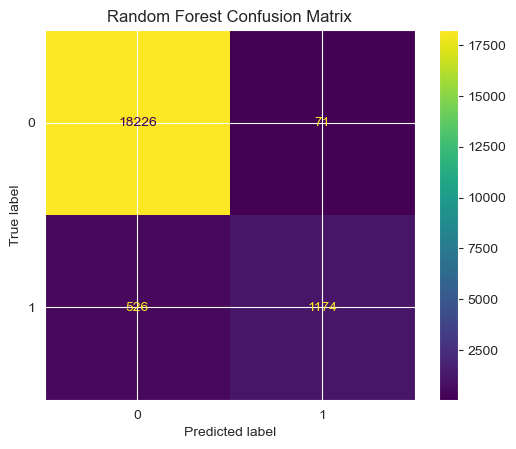

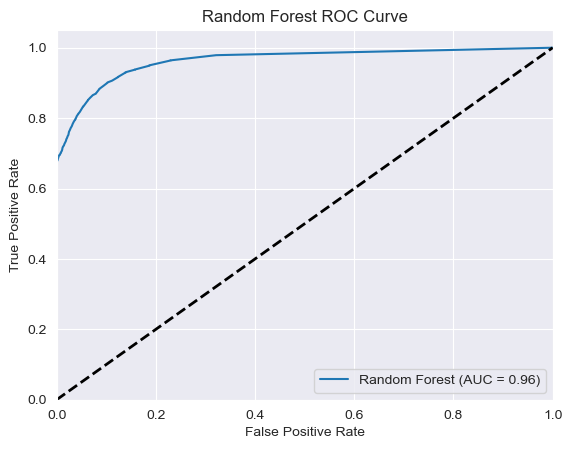

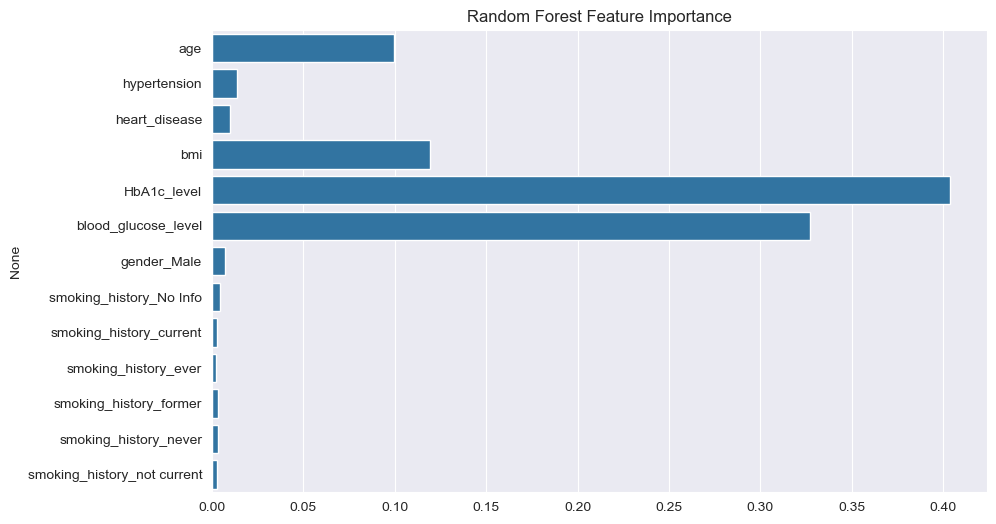

{'Model': 'Random Forest', 'Precision': 0.943, 'Recall': 0.6906, 'F1 Score': 0.7973, 'ROC AUC': 0.9632, 'CV Accuracy': 0.9699, 'CV Std Dev': 0.0004}


In [46]:
# Random Forest Classifier with default parameters
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Evaluate Random Forest Model 
random_forest_results = evaluate_model("Random Forest", random_forest_model)

# Results
print(random_forest_results)

## XGBoost Classifier

Evaluating XGBoost...
Cross-Validation Accuracy for XGBoost: 0.9710 ± 0.0004
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18297
           1       0.96      0.69      0.80      1700

    accuracy                           0.97     19997
   macro avg       0.96      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



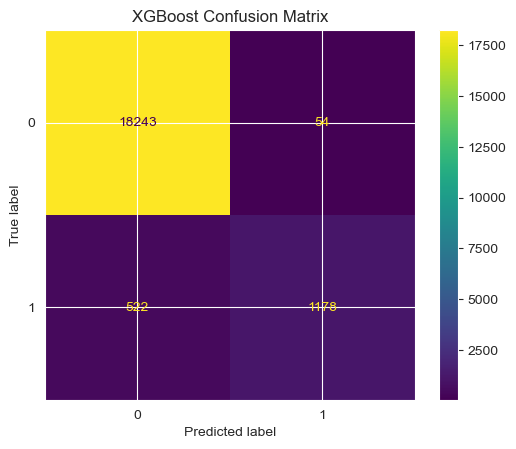

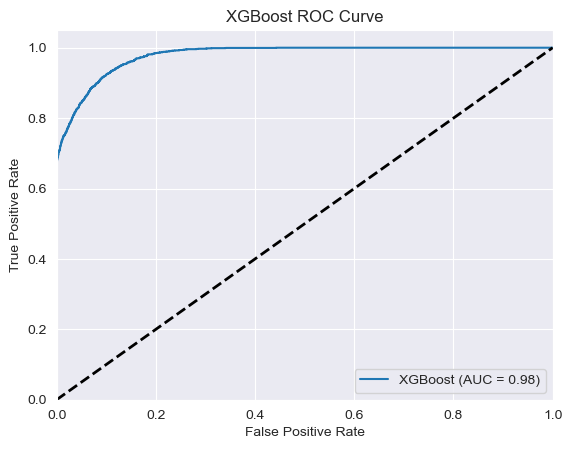

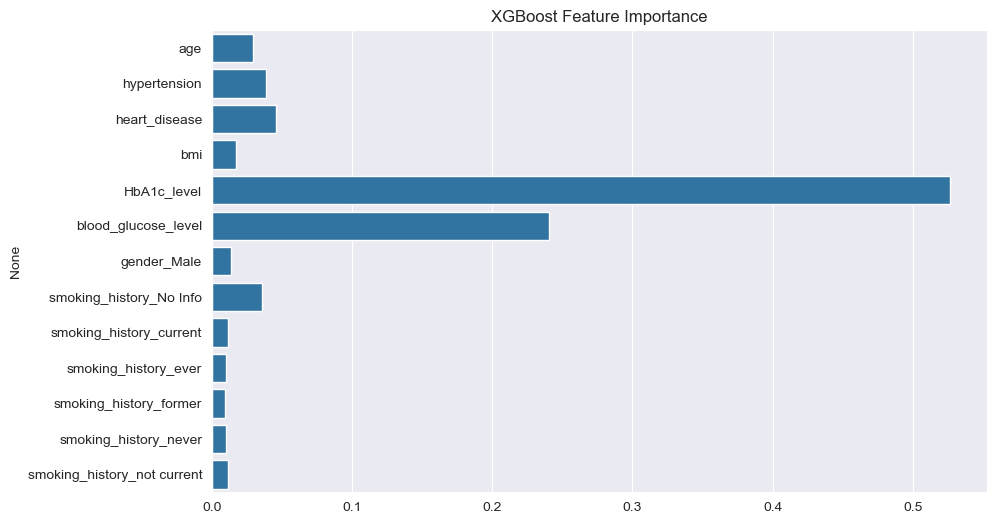

{'Model': 'XGBoost', 'Precision': 0.9562, 'Recall': 0.6929, 'F1 Score': 0.8035, 'ROC AUC': 0.9783, 'CV Accuracy': 0.971, 'CV Std Dev': 0.0004}


In [45]:
# XGBoost Classifier with default parameters
xgboost_model = XGBClassifier(random_state=RANDOM_STATE)

# Evaluate XGBoost Model 
xgboost_results = evaluate_model("XGBoost", xgboost_model)

# Results
print(xgboost_results)

## LightGBM Classifier

Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5440, number of negative: 58548
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 63988, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085016 -> initscore=-2.376068
[LightGBM] [Info] Start training from score -2.376068
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5440, number of negative: 58548
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

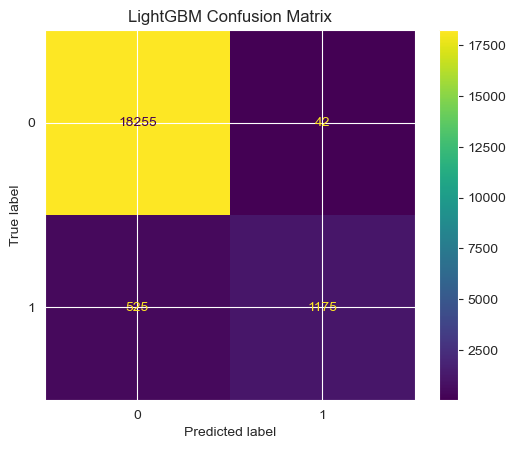

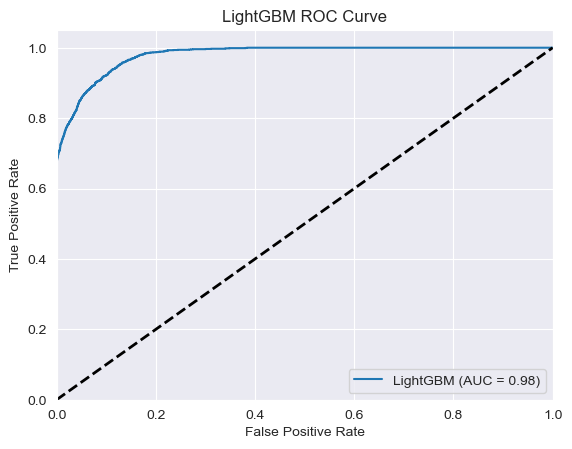

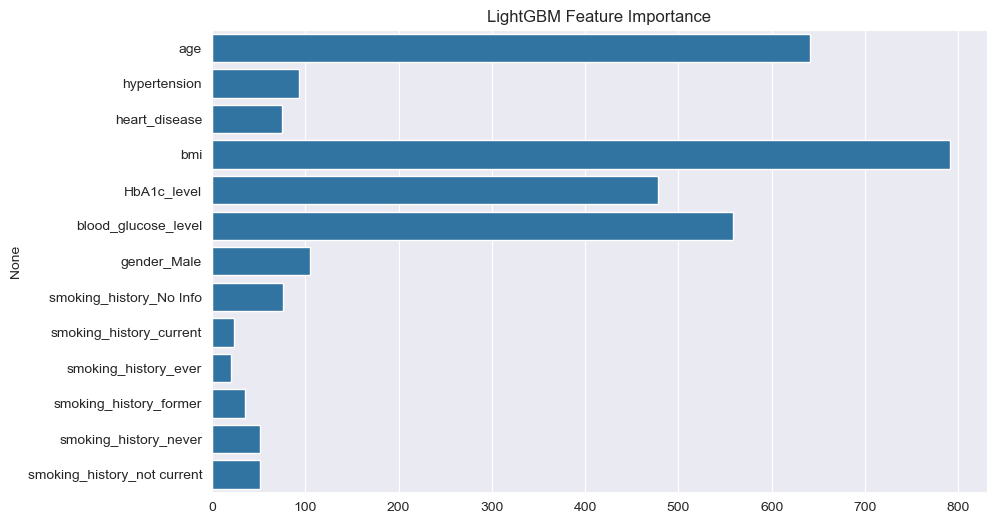

{'Model': 'LightGBM', 'Precision': 0.9655, 'Recall': 0.6912, 'F1 Score': 0.8056, 'ROC AUC': 0.9792, 'CV Accuracy': 0.9717, 'CV Std Dev': 0.0005}


In [48]:
# LightGBM Classifier with default parameters
lightgbm_model = LGBMClassifier(random_state=RANDOM_STATE, ver)

# Evaluate LightGBM Model 
lightgbm_results = evaluate_model("LightGBM", lightgbm_model)

# Results
print(lightgbm_results)

## Catboost Classifier

Evaluating CatBoost...
Cross-Validation Accuracy for CatBoost: 0.9718 ± 0.0005
Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18297
           1       1.00      0.67      0.80      1700

    accuracy                           0.97     19997
   macro avg       0.99      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



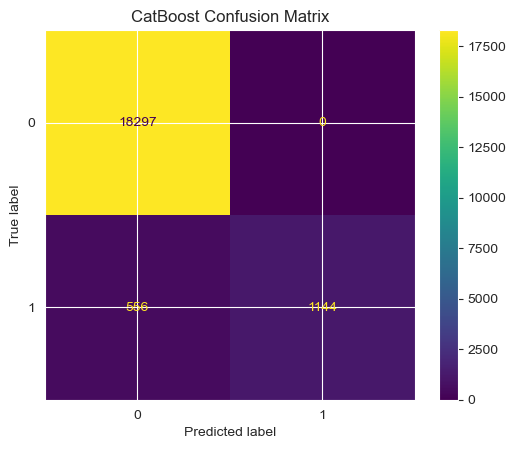

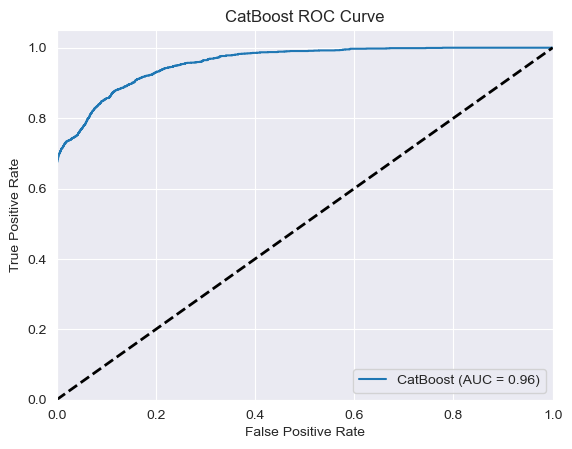

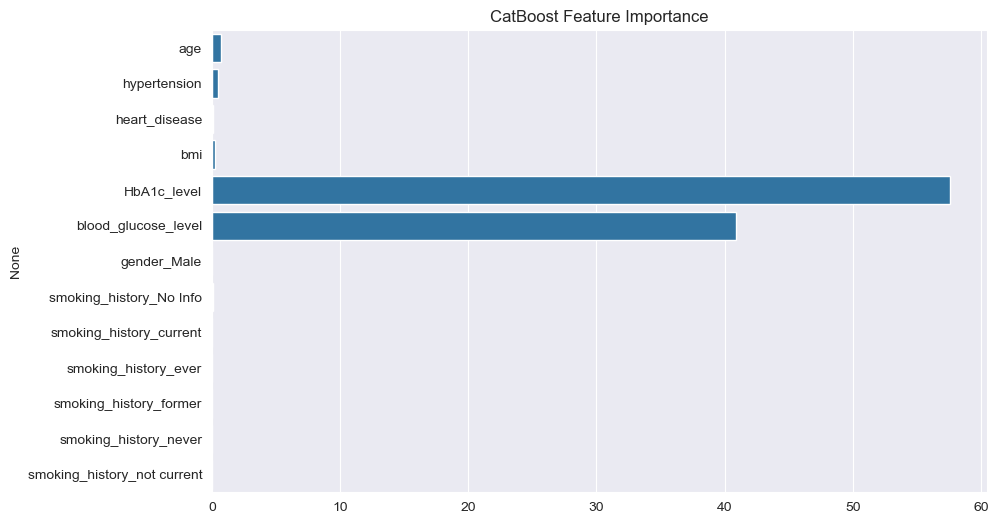

{'Model': 'CatBoost', 'Precision': 1.0, 'Recall': 0.6729, 'F1 Score': 0.8045, 'ROC AUC': 0.958, 'CV Accuracy': 0.9718, 'CV Std Dev': 0.0005}


In [49]:
# CatBoost Classifier 
catboost_model = CatBoostClassifier(iterations=100,
                                    depth=3,
                                    learning_rate=0.01,
                                    random_seed=RANDOM_STATE,
                                    verbose=False)

# Evaluate CatBoost Model 
catboost_results = evaluate_model("CatBoost", catboost_model)

# Results
print(catboost_results)

## Summary

In [50]:
results_list = [
    decision_tree_results,
    random_forest_results,
    xgboost_results,
    lightgbm_results,
    catboost_results
]

results_df = pd.DataFrame(results_list).set_index('Model')

# Display the table of results.
print(results_df)

# Saving the results
# results_df.to_csv('model_evaluation_results.csv')


               Precision  Recall  F1 Score  ROC AUC  CV Accuracy  CV Std Dev
Model                                                                       
Decision Tree     0.7030  0.7435    0.7227   0.8570       0.9519      0.0012
Random Forest     0.9430  0.6906    0.7973   0.9632       0.9699      0.0004
XGBoost           0.9562  0.6929    0.8035   0.9783       0.9710      0.0004
LightGBM          0.9655  0.6912    0.8056   0.9792       0.9717      0.0005
CatBoost          1.0000  0.6729    0.8045   0.9580       0.9718      0.0005
